In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from neuralop.models import FNO

# Load your data
data = pd.read_csv('pvessel_0003.csv', delimiter=';')

print(data.shape)
print(data.head())

X, Y, Z = data['X'].values, data['Y'].values, data['Z'].values

VonMises = data['VonMises'].values
Thickness = data['Thickness'].values.astype(np.float32)


(7440, 9)
           Part Name  Node ID          X          Y           Z  Thickness   
0  PRESSURE_VESSEL-1        3  1417.4429 -1417.4429  2400.00000   9.134000  \
1  PRESSURE_VESSEL-1        4  1417.4429 -1417.4429     0.00000   9.283225   
2  PRESSURE_VESSEL-1        5  1417.4429  1417.4429     0.00000   9.134000   
3  PRESSURE_VESSEL-1        6  1417.4429  1417.4429  2400.00000   9.134000   
4  PRESSURE_VESSEL-1       11  1967.4427   384.0025   874.90546   9.750650   

          S11         S22    VonMises  
0   34.744904   31.558626   38.098473  
1    6.286427   20.401562   18.279026  
2    3.830193   11.801309   11.850667  
3   42.997320   30.993147   42.989639  
4  109.786446  144.928470  171.783295  


Text(0, 0.5, 'Z')

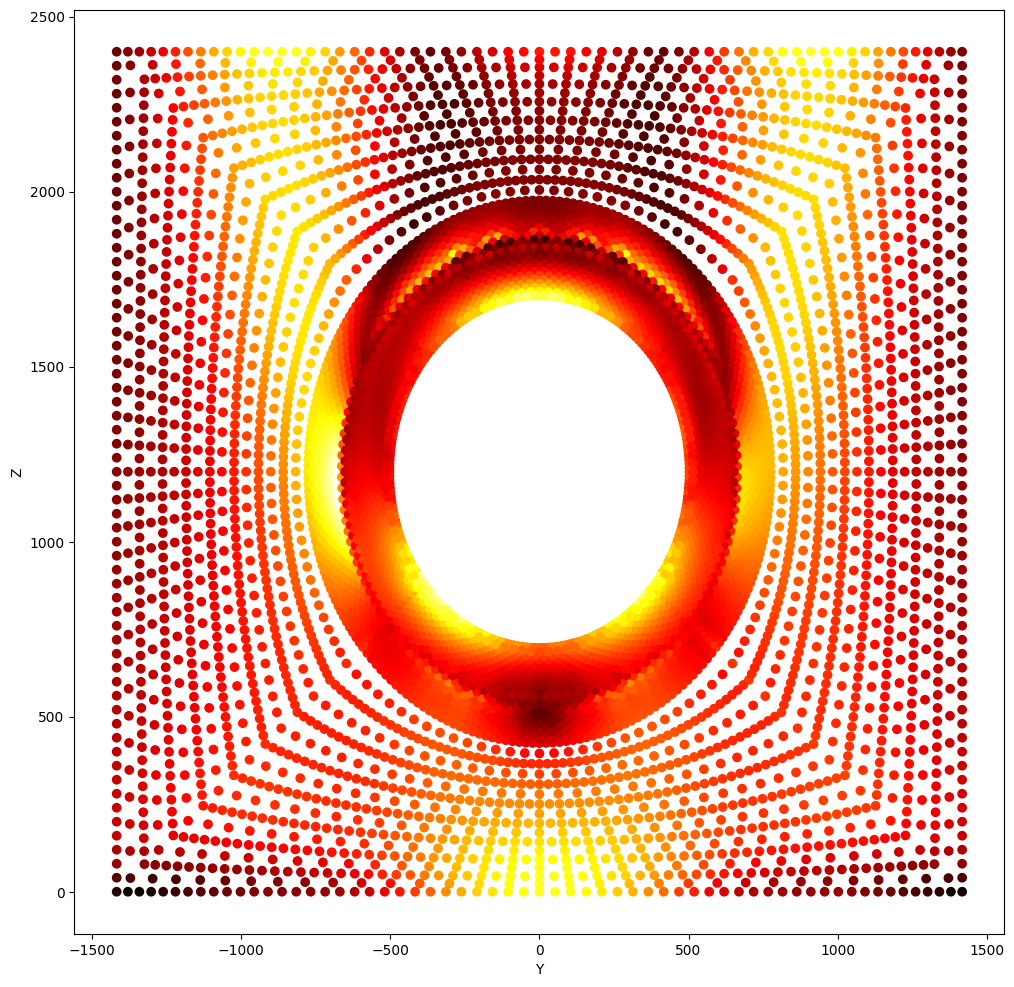

In [156]:
# fig = plt.figure(figsize=(12, 12))
# ax = fig.add_subplot()

# # ax.scatter(X, Y, Z)
# ax.scatter(Y, Z, c=VonMises, cmap='hot')
# ax.set_xlabel('Y')
# ax.set_ylabel('Z')
# # ax.set_zlabel('Z')

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot()

# ax.scatter(X, Y, Z)
ax.scatter(Y, Z, c=VonMises, cmap='hot')
ax.set_xlabel('Y')
ax.set_ylabel('Z')
# ax.set_zlabel('Z')

In [ ]:
print(Y.shape, Z.shape)
points = np.stack((Y, Z))
print(points.shape)


from scipy.interpolate import griddata
ymin, ymax = np.min(Y), np.max(Y)
zmin, zmax = np.min(Z), np.max(Z)

y_vals = np.linspace(ymin, ymax, 100)
z_vals = np.linspace(zmin, zmax, 100)
print(ymin, ymax)
print(zmin, zmax)
grid_y, grid_z = np.meshgrid(y_vals, z_vals)

grid_vonmises = griddata(points.T, VonMises, (grid_y, grid_z), method='nearest')

# Define circular hole mask
center_y = (ymax + ymin) / 2
center_z = (zmax + zmin) / 2
radius = 1016 / 2  # Assuming same units as Y and Z

mask = np.sqrt((grid_z - center_z)**2 + (grid_y - center_y)**2) < radius

# Set stress in hole region to 0
grid_vonmises[mask] = 0

print(grid_vonmises.shape)
print(grid_y.shape, grid_z.shape)



(7440,) (7440,)
(2, 7440)
-1418.028 1418.028
0.0 2400.0
(100, 100)
(100, 100) (100, 100)


<Axes: >

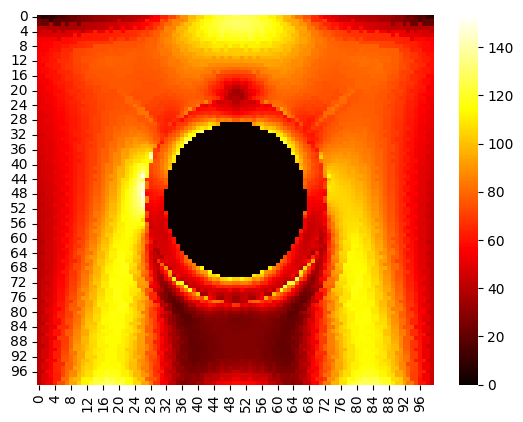

In [117]:
sns.heatmap(grid_vonmises, cmap='hot', cbar=True)

In [122]:
import glob
import pandas as pd
import numpy as np
import torch
from scipy.interpolate import griddata

csv_files = glob.glob('data/**/*pvessel*.csv', recursive=True)

inputs_list = []
targets_list = []

for file in csv_files:
    df = pd.read_csv(file, delimiter=';')
    print(f"Processing file: {file}{' ':<20}", end='\r')
    
    # Try to find the correct column names for Y, Z, VonMises, Thickness
    y_col = 'Y' if 'Y' in df.columns else 'y'
    z_col = 'Z' if 'Z' in df.columns else 'z'
    von_col = 'VonMises' if 'VonMises' in df.columns else 'Mises'
    thick_col = 'Thickness' if 'Thickness' in df.columns else 'thickness'

    Y = df[y_col].values
    Z = df[z_col].values
    VonMises = df[von_col].values
    Thickness = df[thick_col].values.astype(np.float32)

    points = np.stack((Y, Z), axis=-1)

    # Create interpolation grid
    ymin, ymax = np.min(Y), np.max(Y)
    zmin, zmax = np.min(Z), np.max(Z)
    y_vals = np.linspace(ymin, ymax, 100)
    z_vals = np.linspace(zmin, zmax, 100)
    grid_y, grid_z = np.meshgrid(y_vals, z_vals)

    # Interpolate each field
    grid_vonmises = griddata(points, VonMises, (grid_y, grid_z), method='nearest')
    grid_thickness = griddata(points, Thickness, (grid_y, grid_z), method='nearest')

    # Define circular hole mask
    center_y = (ymax + ymin) / 2
    center_z = (zmax + zmin) / 2
    radius = 1016 / 2  # Assuming same units as Y and Z

    mask = np.sqrt((grid_z - center_z)**2 + (grid_y - center_y)**2) < radius

    # # Normalize Y and Z if desired (optional)
    # grid_y_norm = (grid_y - ymin) / (ymax - ymin)
    # grid_z_norm = (grid_z - zmin) / (zmax - zmin)
    grid_thickness[mask] = 0
    grid_vonmises[mask] = 0


    # Stack input channels: Y, Z, Thickness → shape: (3, H, W)
    input_tensor = np.stack([grid_y, grid_z, grid_thickness], axis=0)  # shape: (3, 100, 100)
    target_tensor = np.expand_dims(grid_vonmises, axis=0)  # shape: (1, 100, 100)

    inputs_list.append(torch.tensor(input_tensor, dtype=torch.float32))
    targets_list.append(torch.tensor(target_tensor, dtype=torch.float32))

# Stack into final dataset tensors
inputs = torch.stack(inputs_list)   # shape: (N, 3, 100, 100)
targets = torch.stack(targets_list) # shape: (N, 1, 100, 100)

print(f"Input shape: {inputs.shape}, Target shape: {targets.shape}")


Input shape: torch.Size([998, 3, 100, 100]), Target shape: torch.Size([998, 1, 100, 100])


In [149]:
# 2) Build model
fnomodel = FNO(
	n_modes=(8, 8), # how many fourier modes to keep along each axis
	hidden_channels=16, #width of the latent feature map
	in_channels=3, #input grids
	out_channels=1,
    n_blocks = 4,  # effects the depth
)




In [146]:
import torch
from torch.utils.data import Dataset

class NormalizedTensorDataset(Dataset):
    def __init__(self, inputs, targets):
        """
        inputs: Tensor of shape (N, C_in, H, W)
        targets: Tensor of shape (N, C_out, H, W)
        """
        self.input_mean = inputs.mean(dim=(0, 2, 3), keepdim=True)
        self.input_std = inputs.std(dim=(0, 2, 3), keepdim=True) + 1e-6
        self.target_mean = targets.mean()
        self.target_std = targets.std() + 1e-6

        self.inputs = (inputs - self.input_mean) / self.input_std
        self.targets = (targets - self.target_mean) / self.target_std

    def __len__(self):
        return self.inputs.shape[0]

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

    def denormalize_target(self, t):
        return t * self.target_std + self.target_mean

    def denormalize_input(self, x):
        return x * self.input_std + self.input_mean


In [150]:
from torch.utils.data import TensorDataset, DataLoader, random_split
# Create normalized dataset
full_dataset = NormalizedTensorDataset(inputs, targets)

# Split
num_train = int(0.8 * len(full_dataset))
num_val = len(full_dataset) - num_train
train_dataset, val_dataset = torch.utils.data.random_split(
    full_dataset, [num_train, num_val],
    generator=torch.Generator().manual_seed(42)
)

dataset = TensorDataset(inputs, targets)


num_files, input_channels, height, width = inputs.shape
print(f"Number of files: {num_files}, Input channels: {input_channels}, Height: {height}, Width: {width}")

train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=20)

# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = fnomodel.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.MSELoss()

num_epochs = 100  # You can increase this

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            val_loss += loss.item() * xb.size(0)
    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

Number of files: 998, Input channels: 3, Height: 100, Width: 100
Epoch 1/100 - Train Loss: 0.8716 - Val Loss: 0.5397
Epoch 2/100 - Train Loss: 0.3259 - Val Loss: 0.1769
Epoch 3/100 - Train Loss: 0.1107 - Val Loss: 0.0727
Epoch 4/100 - Train Loss: 0.0588 - Val Loss: 0.0459
Epoch 5/100 - Train Loss: 0.0407 - Val Loss: 0.0348
Epoch 6/100 - Train Loss: 0.0325 - Val Loss: 0.0288
Epoch 7/100 - Train Loss: 0.0275 - Val Loss: 0.0250
Epoch 8/100 - Train Loss: 0.0242 - Val Loss: 0.0236
Epoch 9/100 - Train Loss: 0.0223 - Val Loss: 0.0210
Epoch 10/100 - Train Loss: 0.0215 - Val Loss: 0.0205
Epoch 11/100 - Train Loss: 0.0196 - Val Loss: 0.0188
Epoch 12/100 - Train Loss: 0.0186 - Val Loss: 0.0184
Epoch 13/100 - Train Loss: 0.0178 - Val Loss: 0.0174
Epoch 14/100 - Train Loss: 0.0171 - Val Loss: 0.0179
Epoch 15/100 - Train Loss: 0.0168 - Val Loss: 0.0168


KeyboardInterrupt: 

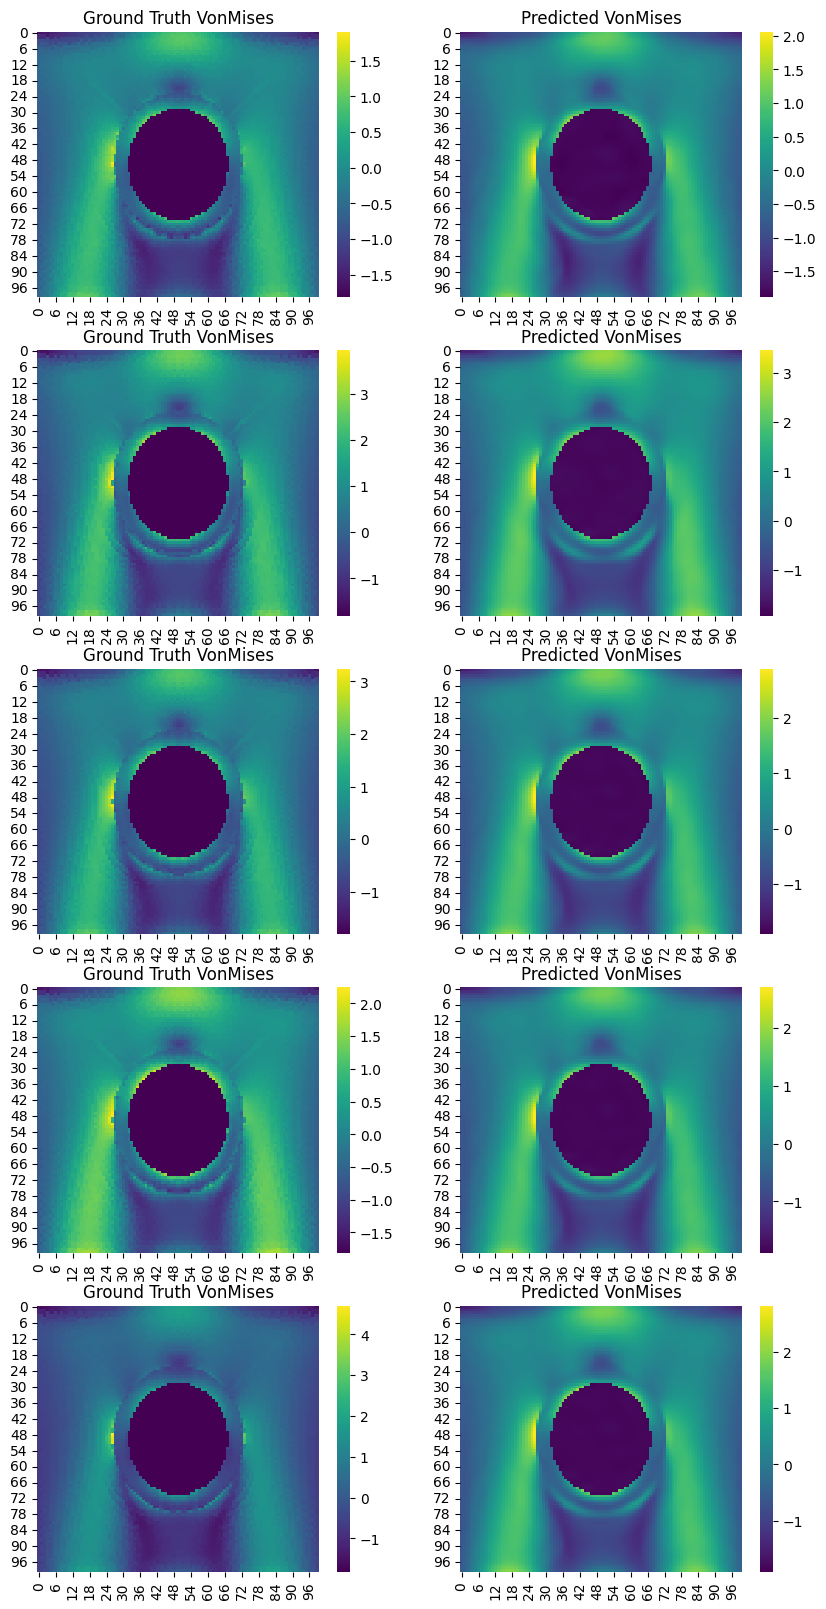

In [151]:

fig, ax = plt.subplots(5, 2, figsize=(10, 20))


for i in range(5):
    random_index = np.random.randint(0, 100)
    x_sample, y_sample = val_dataset[random_index]
    # Get a single (input, target) pair from validation set

    x_sample = x_sample.unsqueeze(0).to(device)  # Shape: (1, 3, 100, 100)
    y_sample = y_sample.unsqueeze(0).to(device)  # Shape: (1, 1, 100, 100)

    model.eval()
    with torch.no_grad():
        y_pred = model(x_sample)  # Output shape: (1, 1, 100, 100)

    # Convert to numpy and squeeze batch/channel dimensions
    y_true_np = y_sample.squeeze().cpu().numpy()
    y_pred_np = y_pred.squeeze().cpu().numpy()

    sns.heatmap(y_true_np, cmap='viridis', cbar=True, ax=ax[i,0])
    sns.heatmap(y_pred_np, cmap='viridis', cbar=True, ax=ax[i,1])
    ax[i,0].set_title('Ground Truth VonMises')
    ax[i,1].set_title('Predicted VonMises')

